In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Device setup: use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
class ParticleGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 4 + num_classes)  # [pt, eta, phi, energy, logits...]
        )

    def forward(self, z):
        out = self.model(z)
        features = out[:, :4]                          # pt, eta, phi, energy
        label_logits = out[:, 4:]                      # raw logits
        label_probs = torch.softmax(label_logits, dim=1)
        return features, label_probs


In [5]:
class ParticleDiscriminator(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super().__init__()
        input_dim = 4 + num_classes
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, features, label_probs):
        x = torch.cat([features, label_probs], dim=1)
        return self.model(x)

In [6]:
# Load the CSV file
df = pd.read_csv("gen_particles_10k_sample.csv")
df.shape

(5058758, 11)

In [7]:
df = df[df.status == 1]
df = df[df['pdg_id'].isin([-12, -11, 11, 12])]
df.shape

(10818, 11)

In [8]:
# Select relevant columns
features = ['pt', 'eta', 'phi', 'energy']
target = 'pdg_id'

In [9]:
label_encoder = LabelEncoder()
df['pdg_label'] = label_encoder.fit_transform(df[target])

In [10]:
# Normalize feature columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

In [11]:
# Convert encoded labels to tensor
y_tensor = torch.tensor(df['pdg_label'].values, dtype=torch.long)

In [12]:
# Create dataset and dataloader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [13]:
# Ready for training
print("Number of particles:", len(dataset))
print("PDG label classes:", label_encoder.classes_)

Number of particles: 10818
PDG label classes: [-12 -11  11  12]


In [15]:
# Hyperparameters
latent_dim = 8
num_classes = len(label_encoder.classes_)
num_epochs = 1000
batch_size = 64

# Models to device
generator = ParticleGenerator(latent_dim=latent_dim, num_classes=num_classes).to(device)
discriminator = ParticleDiscriminator(num_classes=num_classes).to(device)

In [16]:
# Loss and optimizers
adversarial_loss = nn.BCELoss().to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

In [17]:
for epoch in range(num_epochs):
    for real_features, real_labels in dataloader:
        real_features = real_features.to(device)
        real_labels = real_labels.to(device)

        # valid = torch.ones(real_features.size(0), 1, device=device)
        valid = torch.full((real_features.size(0), 1), 0.9, device=device)
        # fake = torch.zeros(real_features.size(0), 1, device=device)
        fake = torch.rand(real_features.size(0), 1, device=device) * 0.1

        # === Generator output ===
        z = torch.randn(real_features.size(0), latent_dim, device=device)
        gen_features, gen_label_probs = generator(z)

        # === Real data ===
        real_onehot = F.one_hot(real_labels, num_classes=num_classes).float()

        # === Train Discriminator ===
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_features, real_onehot), valid)
        fake_loss = adversarial_loss(discriminator(gen_features.detach(), gen_label_probs.detach()), fake)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # === Train Generator ===
        optimizer_G.zero_grad()
        gen_validity = discriminator(gen_features, gen_label_probs)
        g_loss = adversarial_loss(gen_validity, valid)
        g_loss.backward()
        optimizer_G.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch 0 | D Loss: 1.2819 | G Loss: 0.7535
Epoch 100 | D Loss: 1.2981 | G Loss: 0.9247
Epoch 200 | D Loss: 1.3310 | G Loss: 0.9233
Epoch 300 | D Loss: 1.3082 | G Loss: 0.8664
Epoch 400 | D Loss: 1.3603 | G Loss: 0.7468
Epoch 500 | D Loss: 1.4152 | G Loss: 0.7195
Epoch 600 | D Loss: 1.1502 | G Loss: 0.9005
Epoch 700 | D Loss: 1.3936 | G Loss: 0.7543
Epoch 800 | D Loss: 1.3965 | G Loss: 0.7243
Epoch 900 | D Loss: 1.1787 | G Loss: 0.7326


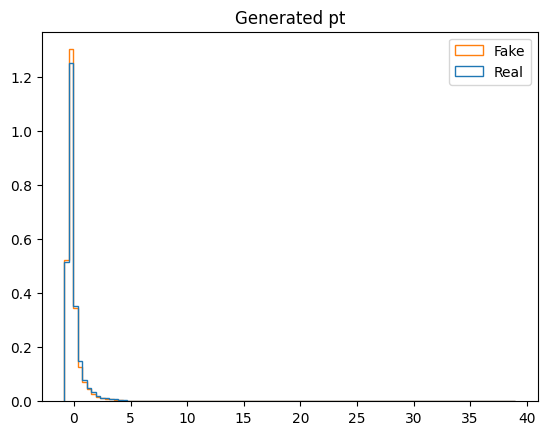

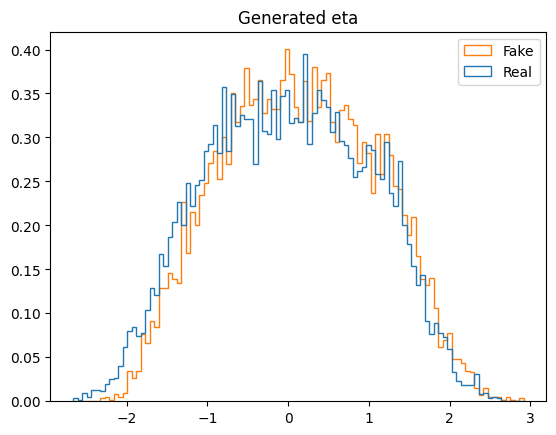

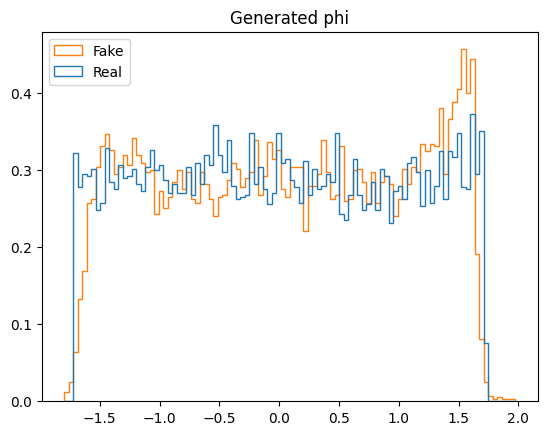

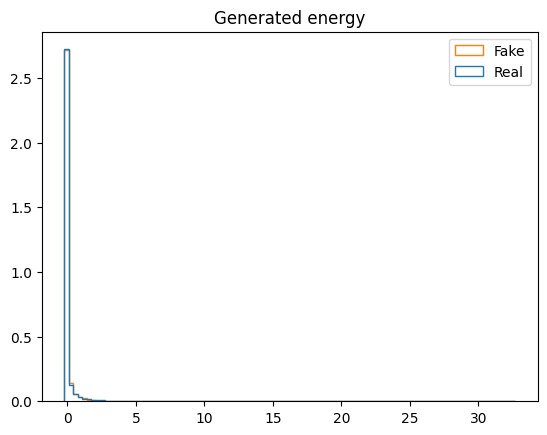

In [19]:
with torch.no_grad():
    z = torch.randn(df.shape[0], latent_dim, device=device)
    f, l = generator(z)
    f = f.cpu().numpy()
    gen_labels = torch.argmax(l, dim=1).cpu().numpy()

for i, fn in enumerate(features):
    plt.hist([X_tensor[:, i], f[:, i]], bins=100, label=["Real","Fake"], density=True, histtype='step')
    plt.legend()
    plt.title(f"Generated {fn}")
    plt.show()

In [20]:
gen_part_types = label_encoder.inverse_transform(gen_labels)
np.unique(gen_part_types, return_counts=True)

(array([-12, -11,  11,  12]), array([ 147, 5118, 5471,   82]))

In [21]:
real_counts = np.array([(df['pdg_id'].values == pid).sum() for pid in label_encoder.classes_])
gen_counts = np.array([(gen_part_types == pid).sum() for pid in label_encoder.classes_])

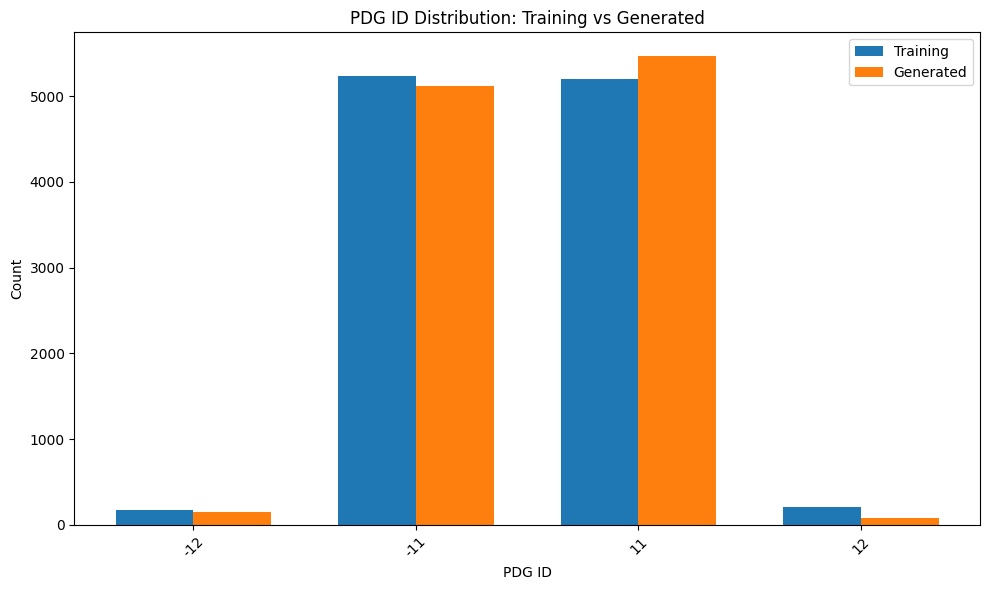

In [22]:
x = np.arange(len(label_encoder.classes_))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, real_counts, width, label='Training')
plt.bar(x + width/2, gen_counts, width, label='Generated')

plt.xlabel('PDG ID')
plt.ylabel('Count')
plt.title('PDG ID Distribution: Training vs Generated')
plt.xticks(ticks=x, labels=label_encoder.classes_.astype(str), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import torch
torch.randn(1).to("cuda")